# A. Solution Overview

## A1. Multi-stage architect approach

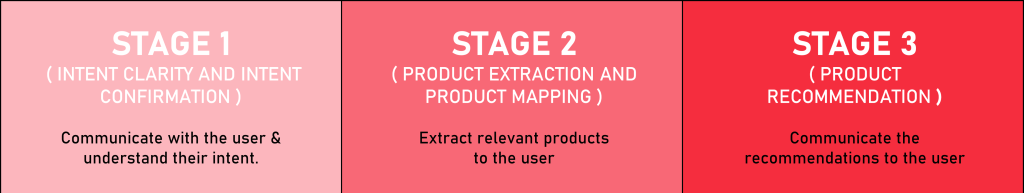

The overall approach you will follow throughout this chatbot creation journey is as follows:

- ***Conversation and Information Gathering***: The chatbot will utilise language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user’s requirements.

- ***Information Extraction***: Once the essential information is collected, rule-based functions come into play, extracting the top three laptops that best match the user’s needs.

- ***Personalised Recommendation***: Leveraging the extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in finding the perfect laptop solution.

## A2. Chatbot System design

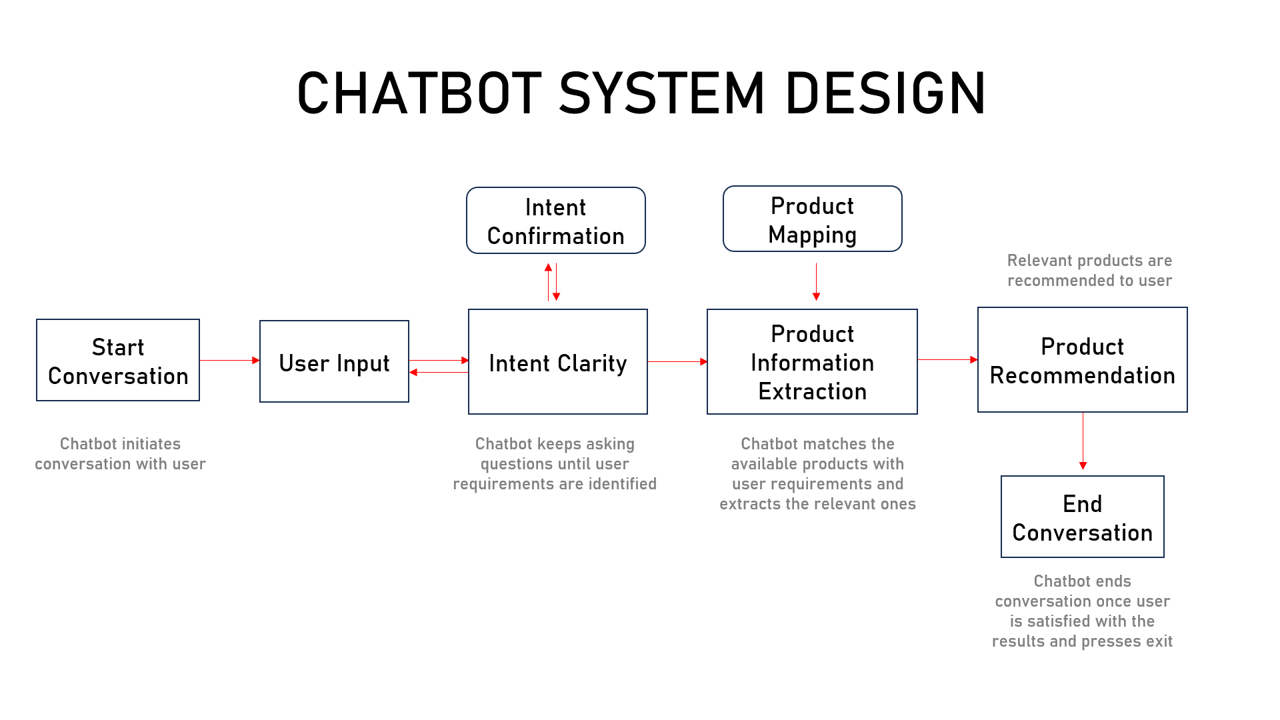

### A2.1 [Stage 1] Intent Clatification

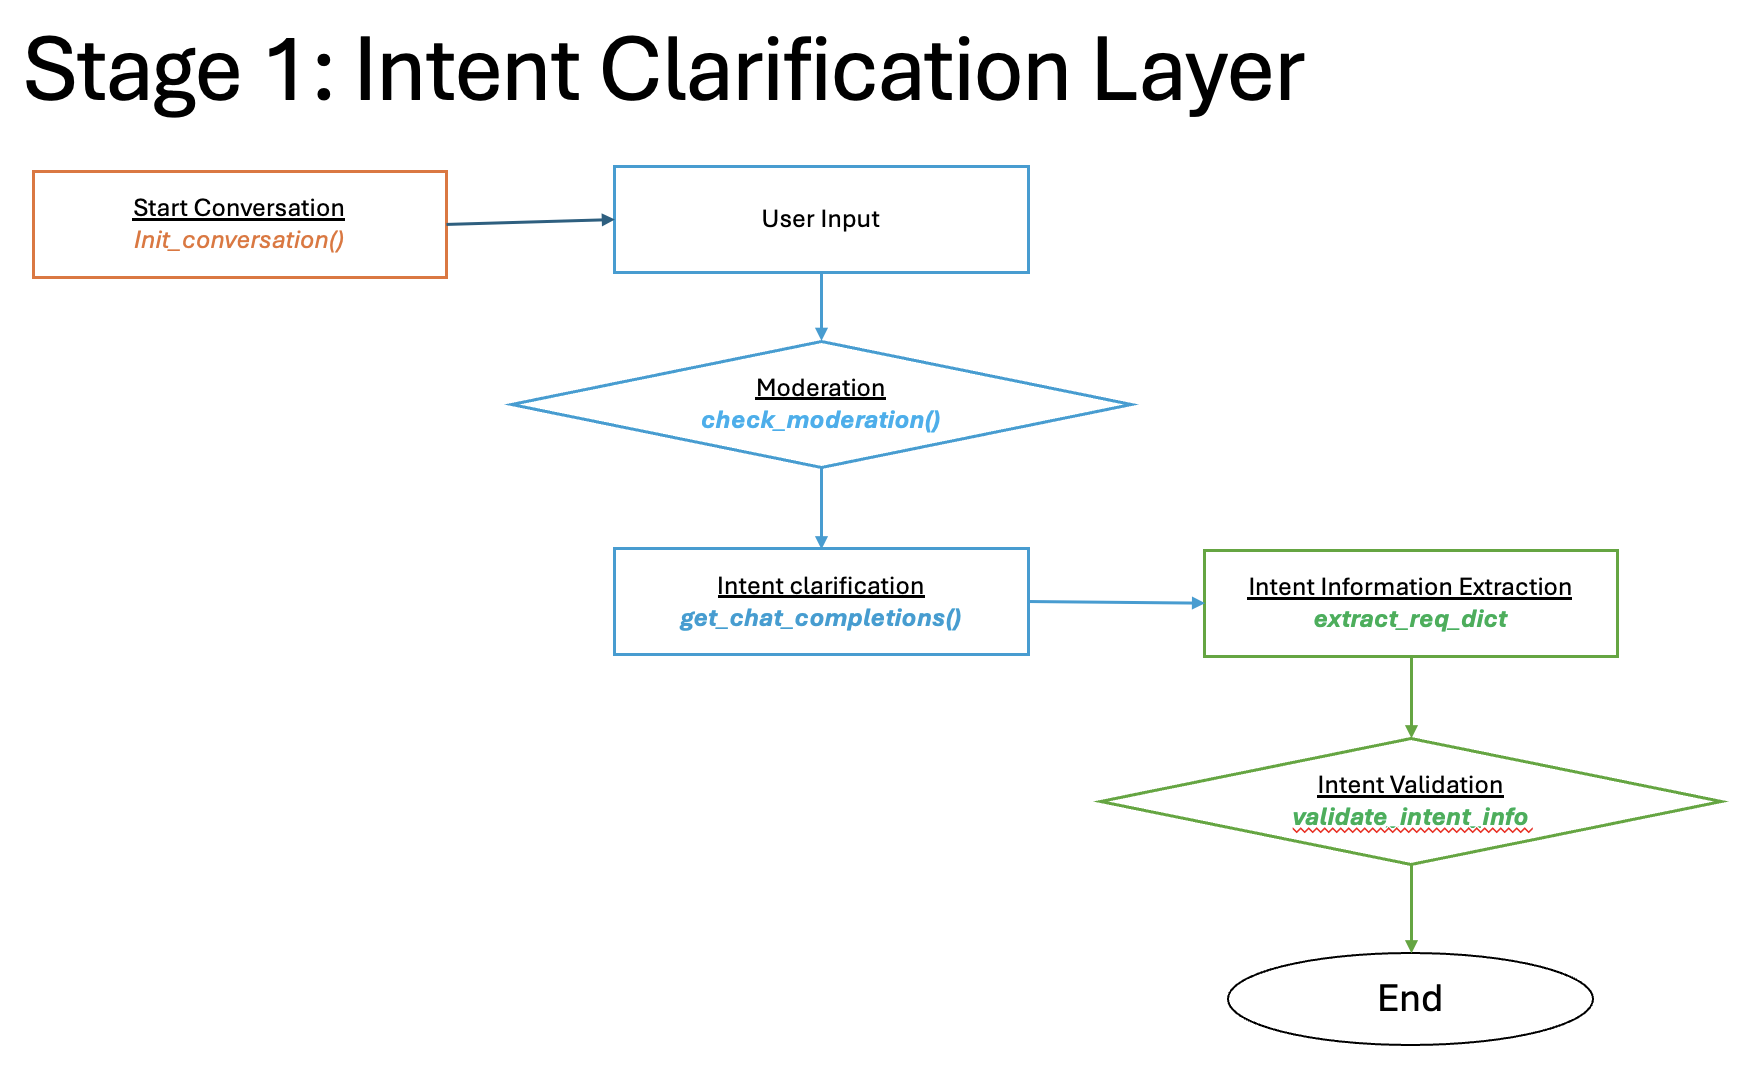

### A2.2 [Stage 2] Product Mapping and Information Extraction

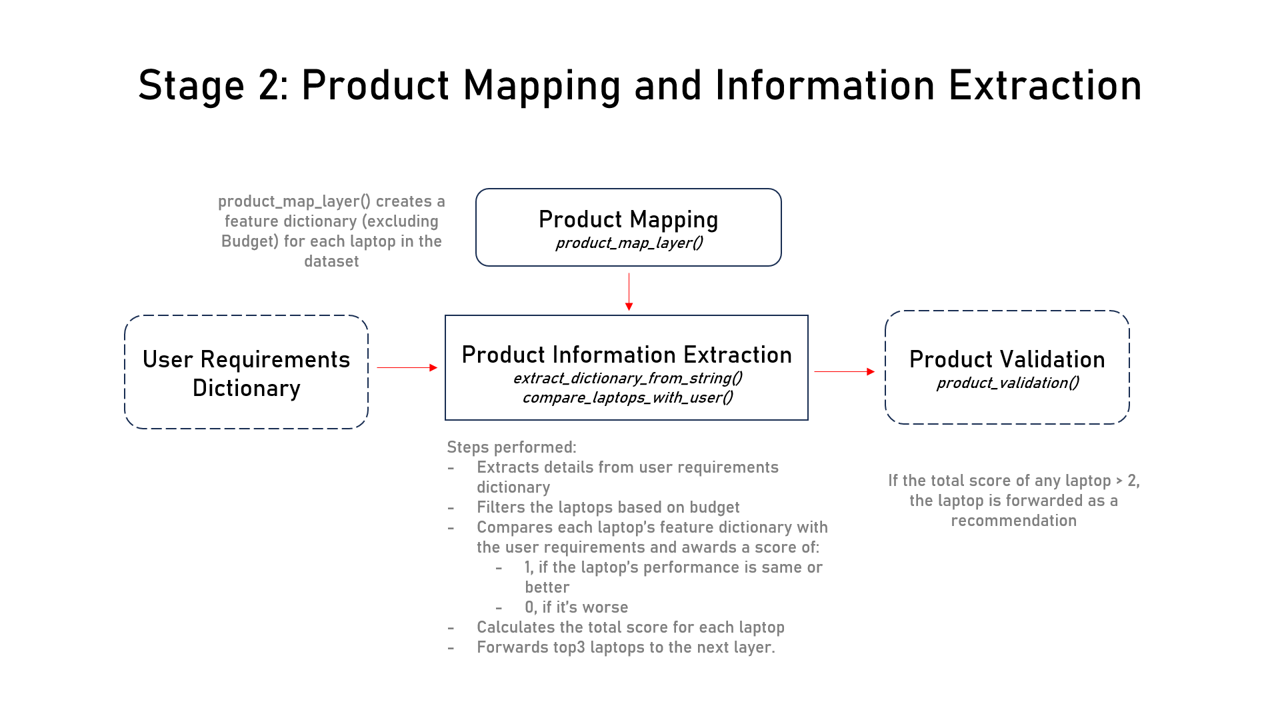

### A2.3 Product Recommendation

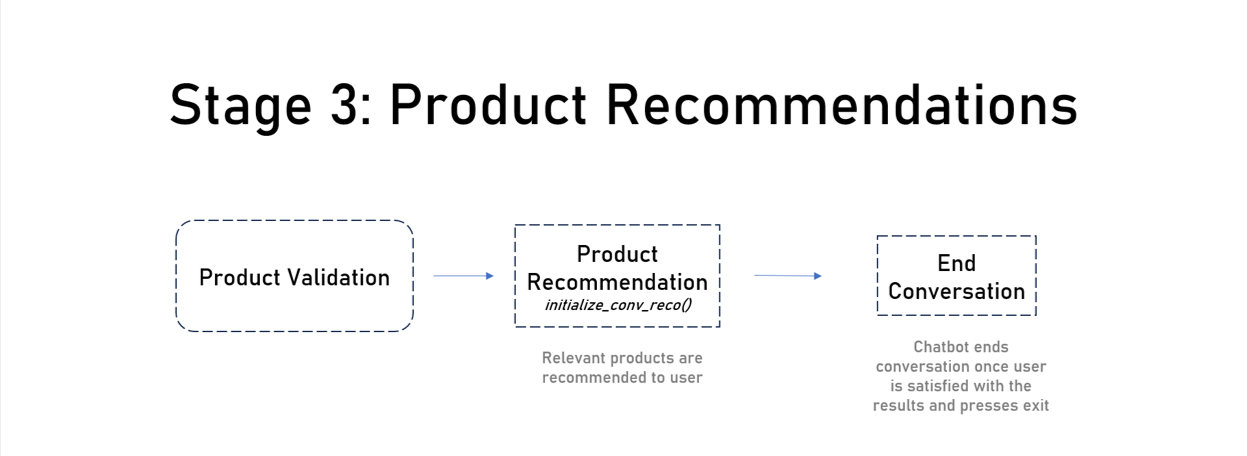

# B. Implementation

## B1. Preparation

In [1]:
PRODUCT_FILEPATH = '/content/drive/MyDrive/Colab Notebooks/[C5.M3] Chatbot System Design and Building ShopAssist AI/ShopAssist_ Data + Demo/laptop_data.csv'

OPENAI_KEYFILE = '/content/drive/MyDrive/Colab Notebooks/[C5.M2] Introduction to GenAI and Working with OpenAI APIs/openAI/OpenAI_API_Key.txt'

GPT_MODEL = 'gpt-4o-mini'

### B1.1 Import openai

In [2]:
!pip install openai

In [3]:
import openai

In [4]:
# Read openai key from file
with open(OPENAI_KEYFILE, 'r') as f:
    OPENAI_KEY = f.readline()

# Apply API key for openai
openai.api_key = OPENAI_KEY

### B1.2 Load product data

In [5]:
import pandas as pd

In [6]:
df_product = pd.read_csv(PRODUCT_FILEPATH)

df_product.head(3)

,Brand,Model Name,Core,CPU Manufacturer,Clock Speed,RAM Size,Storage Type,Display Type,Display Size,Graphics Processor,Screen Resolution,OS,Laptop Weight,Special Features,Warranty,Average Battery Life,Price,Description
0,Dell,Inspiron,i5,Intel,2.4 GHz,8GB,SSD,LCD,"15.6""",Intel UHD,1920x1080,Windows 10,2.5 kg,Backlit Keyboard,1 year,6 hours,"35,000",The Dell Inspiron is a versatile laptop that c...
1,MSI,GL65,i7,Intel,2.6 GHz,16GB,HDD+SSD,IPS,"15.6""",NVIDIA GTX,1920x1080,Windows 10,2.3 kg,RGB Keyboard,2 years,4 hours,"55,000",The MSI GL65 is a high-performance laptop desi...
2,HP,EliteBook,i7,Intel,2.8 GHz,16GB,SSD,LED,"14""",Intel UHD,1920x1080,Windows 11,1.5 kg,Fingerprint Sensor,3 years,8 hours,"90,000",The HP EliteBook is a premium laptop designed ...


In [7]:
df_product.shape

(20, 18)

In [8]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Brand                 20 non-null     object
 1   Model Name            20 non-null     object
 2   Core                  20 non-null     object
 3   CPU Manufacturer      20 non-null     object
 4   Clock Speed           20 non-null     object
 5   RAM Size              20 non-null     object
 6   Storage Type          20 non-null     object
 7   Display Type          20 non-null     object
 8   Display Size          20 non-null     object
 9   Graphics Processor    20 non-null     object
 10  Screen Resolution     20 non-null     object
 11  OS                    20 non-null     object
 12  Laptop Weight         20 non-null     object
 13  Special Features      20 non-null     object
 14  Warranty              20 non-null     object
 15  Average Battery Life  20 non-null     obje

In [9]:
df_product['Description'].iloc[0]

'The Dell Inspiron is a versatile laptop that combines powerful performance and affordability. It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing. With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity. The laptop sports a vibrant 15.6" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience. Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage. Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience. With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment. All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users.'

### B1.3 [COMMON] Iterate LLM response

In [10]:
def iterate_llm_response(funct, funct_params, num = 10):
    """
    Calls a specified function repeatedly and prints the results.
    This function is designed to test the consistency of a response from a given function.
    It calls the function multiple times (default is 10) and prints out the iteration count,
    the function's response(s).
    Args:
        funct (function): The function to be tested. This function should accept a single argument
                          and return the response value(s).
        input_message (dict): The input argument to be passed to 'funct' on each call.
        num (int, optional): The number of times 'funct' will be called. Defaults to 10.
    Returns:
        This function only returns the results to the console.
    """
    i = 0  # Initialize counter

    while i < num:  # Loop to call the function 'num' times

        response = funct(funct_params)  # Call the function with the debug response

        # Print the iteration number, result, and reason from the response
        print("Iteration: {0}".format(i))
        print(response)
        print('-' * 50)  # Print a separator line for readability
        i += 1  # Increment the counter

# Example usage: test the consistency of responses from 'intent_confirmation_layer'
# iterate_llm_response(get_chat_completions, messages)

## B1. [Stage 1] Intent Clarity & Confirmation

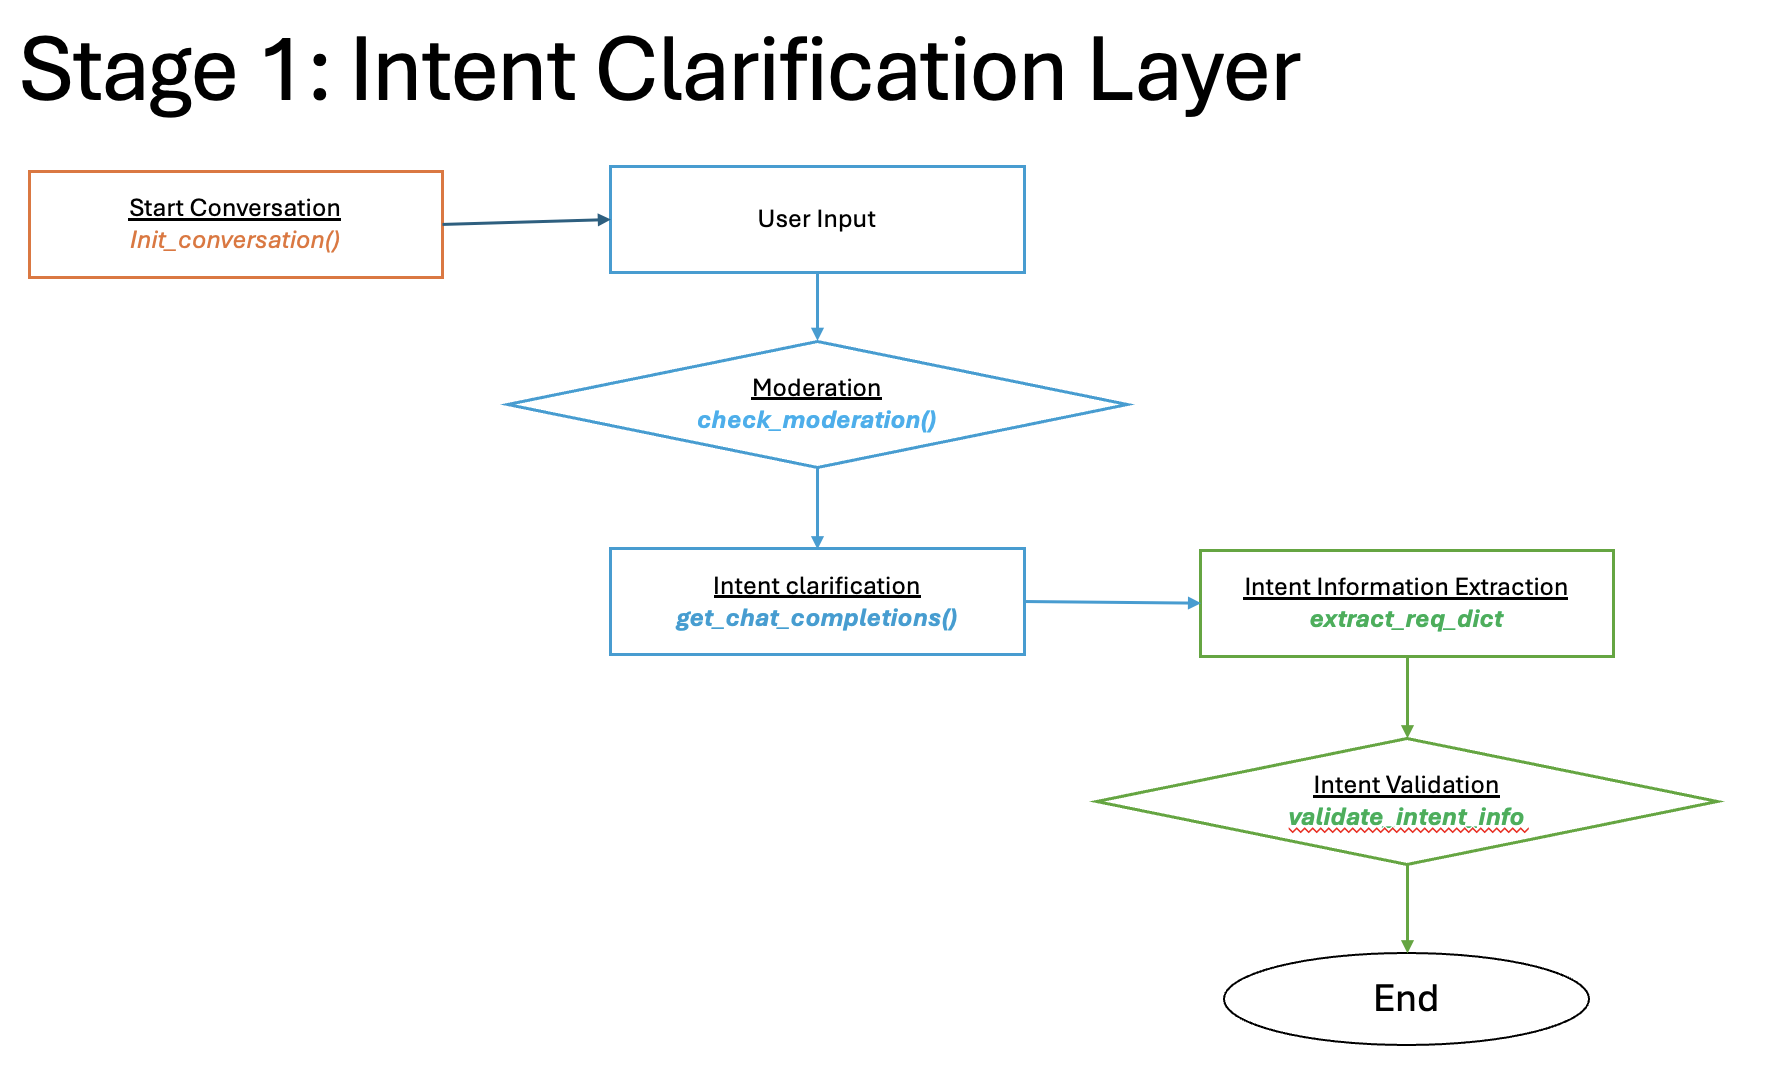

### B1.1 [COMMON] init_conversation()

In [11]:
def init_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    delimiter = "####"

    example_user_dict = {"GPU intensity": "high",
                        "Display quality":"high",
                        "Portability": "low",
                        "Multitasking": "high",
                        "Processing speed": "high",
                        "Budget": 150000}

    example_user_req = {"GPU intensity": "_",
                        "Display quality": "_",
                        "Portability": "_",
                        "Multitasking": "_",
                        "Processing speed": "_",
                        "Budget": _}

    system_message = f"""
    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.
    You need to ask relevant questions and understand the user profile by analysing the user's responses.
    The question you ask should be wrapped to multi-lines, each lines 20 words max
    You final objective is to fill the values for the different keys ('GPU intensity','Display quality','Portability','Multitasking','Processing speed','Budget') in the python dictionary and be confident of the values.
    These key value pairs define the user's profile.
    The python dictionary looks like this
    {{'GPU intensity': 'values','Display quality': 'values','Portability': 'values','Multitasking': 'values','Processing speed': 'values','Budget': 'values'}}
    The value for 'Budget' should be a numerical value extracted from the user's response.
    The values for all keys, except 'Budget', should be 'low', 'medium', or 'high' based on the importance of the corresponding keys, as stated by user.
    All the values in the example dictionary are only representative values.
    {delimiter}
    Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalised:
    - The values for all keys, except 'Budget', should strictly be either 'low', 'medium', or 'high' based on the importance of the corresponding keys, as stated by user.
    - The value for 'Budget' should be a numerical value extracted from the user's response.
    - 'Budget' value needs to be greater than or equal to 25000 INR. If the user says less than that, please mention that there are no laptops in that range.
    - Do not randomly assign values to any of the keys.
    - The values need to be inferred from the user's response.
    {delimiter}

    To fill the dictionary, you need to have the following chain of thoughts:
    Follow the chain-of-thoughts below and only output the final updated python dictionary for the keys as described in {example_user_req}. \n
    {delimiter}
    Thought 1: Ask a question to understand the user's profile and requirements. \n
    If their primary use for the laptop is unclear. Ask followup questions to understand their needs.
    You are trying to fill the values of all the keys {{'GPU intensity','Display quality','Portability','Multitasking','Processing speed','Budget'}} in the python dictionary by understanding the user requirements.
    Identify the keys for which you can fill the values confidently using the understanding. \n
    Remember the instructions around the values for the different keys.
    If the necessary information has been extracted, only then proceed to the next step. \n
    Otherwise, rephrase the question to capture their profile clearly. \n

    {delimiter}
    Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step.
    Remember the instructions around the values for the different keys.
    Ask questions you might have for all the keys to strengthen your understanding of the user's profile.
    If yes, move to the next Thought. If no, ask question on the keys whose values you are unsure of. \n
    It is a good practice to ask question with a sound logic as opposed to directly citing the key you want to understand value for.
    {delimiter}

    {delimiter}
    Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
    If you are not confident about any of the values, ask clarifying questions.
    {delimiter}

    {delimiter}
    Here is a sample conversation between the user and assistant:
    User: "Hi, I am an editor."
    Assistant: "Great! As an editor, you likely require a laptop that can handle demanding tasks. Hence, the laptop should have high multitasking capability. You would also need a high end display for better visuals and editing. May I know what kind of work do you primarily focus on? Are you more involved in video editing, photo editing, or both? Understanding the specific type of editing work will help me tailor my recommendations accordingly. Let me know if my understanding is correct until now."
    User: "I primarily work with After Effects."
    Assistant: "Thank you for providing that information. Working with After Effects involves working with graphics, animations, and rendering, which will require high GPU. Do you work with high-resolution media files, such as 4K videos or RAW photos? Understanding your file sizes will help determine the storage capacity and processing power needed."
    User: "Yes, sometimes I work with 4K videos as well."
    Assistant: "Thank you for the information. Processing 4K vidoes will require a good processor and high GPU. I think we have already determined earlier that you need a high GPU. To ensure I have a complete understanding of your needs, I have one more question: Are you frequently on the go and require a laptop that is lightweight and easy to carry, or do you primarily work from a stationary location?"
    User: "Yes, sometimes I travel but do not carry my laptop."
    Assistant:"Could you kindly let me know your budget for the laptop? This will help me find options that fit within your price range while meeting the specified requirements."
    User: "my max budget is 1.5lakh inr"
    Assistant: "{example_user_dict}"
    {delimiter}

    Start with a short welcome message and encourage the user to share their requirements.
    """
    conversation = [{"role": "system", "content": system_message}]
    # conversation = system_message
    return conversation

In [12]:
init_conversation()

[{'role': 'system',
  'content': '\n    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.\n    You need to ask relevant questions and understand the user profile by analysing the user\'s responses.\n    The question you ask should be wrapped to multi-lines, each lines 20 words max \n    You final objective is to fill the values for the different keys (\'GPU intensity\',\'Display quality\',\'Portability\',\'Multitasking\',\'Processing speed\',\'Budget\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'GPU intensity\': \'values\',\'Display quality\': \'values\',\'Portability\': \'values\',\'Multitasking\': \'values\',\'Processing speed\': \'values\',\'Budget\': \'values\'}\n    The value for \'Budget\' should be a numerical value extracted from the user\'s response.\n    The values for all keys, except \'Budget\', should be \'lo

### B1.2 [COMMON] check_moderation()

In [13]:
# Define a function called moderation_check that takes user_input as a parameter.

def check_moderation(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

In [14]:
check_moderation('I want to kill you')

'Flagged'

### B1.3 [COMMON] get_chat_completions()

In [15]:
from tenacity import retry, wait_random_exponential, stop_after_attempt # Handle Retry
import json

# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_completions(prompt_message, json_format = False):
    MODEL = GPT_MODEL

    system_message_json_output = """<<. Return output in JSON format to the key output.>>"""

    # If the output is required to be in JSON format
    if json_format == True:
        # Append the prompt_message to include JSON response as specified by OpenAI
        prompt_message[0]['content'] += system_message_json_output

        # JSON return type specified
        chat_completion_json = openai.chat.completions.create(
            model = MODEL,
            messages = prompt_message,
            response_format = { "type": "json_object"},
            seed = 1234)

        response_message = json.loads(chat_completion_json.choices[0].message.content)

    # No JSON return type specified
    else:
        chat_completion = openai.chat.completions.create(
            model = MODEL,
            messages = prompt_message,
            seed = 2345)

        response_message = chat_completion.choices[0].message.content

    return response_message

In [16]:
# Testing the OpenAI functions defined above
input_prompt ='What is the capital of France?'
messages = [{'role':'user','content':input_prompt}]
messages



[{'role': 'user', 'content': 'What is the capital of France?'}]

In [17]:
## Get LLM Outputs - normal
get_chat_completions(messages) ## Chat Completions API

'The capital of France is Paris.'

In [18]:
## Get LLM Outputs - Json
get_chat_completions(messages, True) ## Chat Completions API

{'output': 'Paris'}

###---- B1.4 [COMMON] is_intent_clarification_finished()

This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not
   - GPU intensity
   - Display quality
   - Portability
   - Multitasking
   - Processing speed
   - Budget

In [19]:
def is_intent_clarification_finished(response_assistant):

    delimiter = "####"

    allowed_values = {'low','medium','high'}

    prompt = f"""
    You are a senior evaluator who has an eye for detail.The input text will contain a user requirement captured through 6 keys.
    You are provided an input. You need to evaluate if the input text has the following key-value in following format:
    {delimiter}
    Format 1:
        'GPU intensity': 'values',
        'Display quality': 'values',
        'Portability': 'values',
        'Multitasking': 'values',
        'Processing speed': 'values',
        'Budget': number
    {delimiter}
    Format 2: the budget number is inside the single quote
        'GPU intensity': 'values',
        'Display quality': 'values',
        'Portability': 'values',
        'Multitasking':' values',
        'Processing speed': 'values',
        'Budget': 'number'
    {delimiter}
    The values for the keys should only be from the allowed values: {allowed_values}.
    The Budget key can take only a numerical value. The budget numerical value can be put inside quote or outside the quote
    Next you need to evaluate if the keys have the the values filled correctly.
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output a string 'Yes' if the values are correctly filled for all keys, otherwise output 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    THought 3 - Think carefully before the answering.
    """

    messages=[{"role": "system", "content":prompt },
              {"role": "user", "content":f"""Here is the input: {response_assistant}""" }]

    response = openai.chat.completions.create(
                                    model=GPT_MODEL,
                                    messages = messages,
                                    response_format={ "type": "json_object" },
                                    seed = 1234
                                    # n = 5
                                    )

    json_output = json.loads(response.choices[0].message.content)

    return json_output

In [20]:
# Test case 1

response_assistant_tc1 = """{{
    'GPU intensity': 'low',
    'Display quality': 'high',
    'Portability': 'low',
    'Multitasking': 'high',
    'Processing speed': 'low'}}"""

is_intent_clarification_finished(response_assistant = response_assistant_tc1)

{'result': 'No', 'reason': "Missing 'Budget' key"}

In [21]:
# Test case 2

response_assistant_tc2 = """Here is your user profile
        'GPU intensity': 'high',
        'Display quality': 'high',
        'Portability': 'medium',
        'Multitasking': 'low',
        'Processing speed': 'high',
        'Budget': '200000'"""

is_intent_clarification_finished(response_assistant = response_assistant_tc2)

{'result': 'Yes'}

In [22]:
# Test case 2

response_assistant_tc2 = """Here is your user profile
        'GPU intensity': 'high',
        'Display quality': 'high',
        'Portability': 'medium',
        'Multitasking': 'low',
        'Processing speed': 'high',
        'Budget': 200000"""

is_intent_clarification_finished(response_assistant = response_assistant_tc2)

{'result': 'Yes'}

In [23]:
# Test case 3
response_assistant_tc3 = """Thank you for sharing your budget. Based on your requirements and the budget provided, here’s what I have gathered:

    - **GPU intensity**: high (for machine learning and data visualization)
    - **Display quality**: high (for visualizing charts effectively)
    - **Portability**: medium (assuming you might use it at different locations)
    - **Multitasking**: high (for running multiple applications)
    - **Processing speed**: high (to handle large datasets efficiently)
    - **Budget**: 100000

    Here is the final profile for your ideal laptop:

    ```python
    {'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'medium', 'Multitasking': 'high', 'Processing speed': 'high', 'Budget': 100000}
    ```
"""

is_intent_clarification_finished(response_assistant = response_assistant_tc3)

{'result': 'No',
 'reason': "The 'Budget' key value should be in quotes as per the given formats."}

### B1.4 [COMMON] extract_req_dict()

This function checks if the final understanding of user's requirement is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right laptops using dictionary matching.

In [24]:
def extract_req_dict(input_message):
    delimiter = "####"

    user_req = {'GPU intensity': 'high',
                'Display quality': 'high',
                'Portability': 'medium',
                'Multitasking': 'high',
                'Processing speed': 'high',
                'Budget': '200000'}

    prompt = f"""You are a python expert. You are provided an input.
            You have to check if there is a python dictionary present in the string.
            It will have the following format {user_req}.
            Your task is to just extract the relevant values from the input and return only the python dictionary in JSON format.
            The output should match the format as {user_req}. You just return the json including all laptop attributes, don't need to wrap it inside an wrapper field

            {delimiter}
            Make sure that the value of budget is also present in the user input. ###
            The output should contain the exact keys and values as present in the input.
            Ensure the keys and values are in the given format:
            {{
            'GPU intensity': 'low/medium/high ',
            'Display quality':'low/medium/high',
            'Portability':'low/medium/high',
            'Multitasking':'low/medium/high',
            'Processing speed':'low/medium/high',
            'Budget':'numerical value'
            }}
            Here are some sample input output pairs for better understanding:
            {delimiter}
            input 1: - GPU intensity: low - Display quality: high - Portability: low - Multitasking: high - Processing speed: medium - Budget: 50,000 INR
            output 1: {{'GPU intensity': 'low', 'Display quality': 'high', 'Portability': 'low', 'Multitasking': 'high', 'Processing speed': 'medium', 'Budget': 50000}}

            input 2: {{'GPU intensity':     'low', 'Display quality':     'low', 'Portability':    'medium', 'Multitasking': 'medium', 'Processing speed': 'low', 'Budget': '90,000'}}
            output 2: {{'GPU intensity': 'low', 'Display quality': 'low', 'Portability': 'medium', 'Multitasking': 'medium', 'Processing speed': 'low', 'Budget': 90000}}

            input 3: Here is your user profile 'GPU intensity': 'high','Display quality': 'high','Portability': 'medium','Multitasking': 'high','Processing speed': 'high','Budget': '200000 INR'
            output 3: {{'GPU intensity': 'high','Display quality': 'high','Portability': 'medium','Multitasking': 'high','Processing speed': 'high','Budget': 200000}}
            {delimiter}
            """
    messages = [{"role": "system", "content":prompt },
                {"role": "user", "content":f"""Here is the user input: {input_message}""" }]

    dict_req = get_chat_completions(messages, json_format = True)

    return dict_req

In [25]:
sample_response = f"""Thank you for providing your budget.
Based on your budget of 50,000 INR, I will consider this while recommending suitable laptop options for you.
Here is the final recommendation for your laptop:
- GPU intensity: high
- Display quality: high
- Portability: low
- Multitasking: high
- Processing speed: medium
- Budget: 80,000 INR

Please note that these specifications are based on your requirements for surfing and a decent display within your budget.
Let me know if there's anything else I can assist you with!"""

extract_req_dict(input_message=sample_response)

{'GPU intensity': 'high',
 'Display quality': 'high',
 'Portability': 'low',
 'Multitasking': 'high',
 'Processing speed': 'medium',
 'Budget': 80000}

In [26]:
sample_response = """Thank you for sharing your budget. Based on your requirements and the budget provided, here’s what I have gathered:

    - **GPU intensity**: high (for machine learning and data visualization)
    - **Display quality**: high (for visualizing charts effectively)
    - **Portability**: medium (assuming you might use it at different locations)
    - **Multitasking**: high (for running multiple applications)
    - **Processing speed**: high (to handle large datasets efficiently)
    - **Budget**: 100000

    Here is the final profile for your ideal laptop:

    ```python
    {'GPU intensity': 'high', 'Display quality': 'high', 'Portability': 'medium', 'Multitasking': 'high', 'Processing speed': 'high', 'Budget': 100000}
    ```
"""

extract_req_dict(input_message=sample_response)

{'GPU intensity': 'high',
 'Display quality': 'high',
 'Portability': 'medium',
 'Multitasking': 'high',
 'Processing speed': 'high',
 'Budget': 100000}

In [27]:
sample_response = """Thank you for sharing your budget. Based on your requirements and the budget provided, here’s what I have gathered:

"""

extract_req_dict(input_message=sample_response)

{}

In [28]:
sample_response = '''
    ASSISTANT:  Thank you for confirming! So we have:

    - High multitasking capability
    - High display quality

    Now, could you please specify how portable you need your laptop to be? Is it lightweight and easy to carry that you prefer, or do you usually work from a stationary place?

    Also, please share your budget for the laptop so I can find options that meet your needs.

    {'GPU intensity': None, 'Display quality': 'high', 'Portability': None, 'Multitasking': 'high', 'Processing speed': None, 'Budget': None}
'''

extract_req_dict(input_message=sample_response)

{'GPU intensity': None,
 'Display quality': 'high',
 'Portability': None,
 'Multitasking': 'high',
 'Processing speed': None,
 'Budget': None}

### B1.5 [COMMON] validate_intent_info()

In [29]:
def check_int(variable):
    # Check if the variable is already a number (int, float, or complex)
    if isinstance(variable, (int, float, complex)):
        return True, int(variable)

    # Check if the variable is a string and can be converted to a number
    if isinstance(variable, str):
        try:
            int(variable)  # Try to convert the string to a float (handles integers and floats)
            return True, int(variable)
        except ValueError:
            return False, 0

    return False, 0

# Test
check_int('10k')

(False, 0)

In [30]:
def validate_intent_info(req_dict):
    # define
    VALUES_ENUM = ['high', 'medium', 'low']

    # Init counter for keys
    counter = {
        "GPU intensity": 0,
        "Display quality": 0,
        "Portability": 0,
        "Multitasking": 0,
        "Processing speed": 0,
        "Budget": 0
    }

    output_dict = {}

    # validate each key
    for key in req_dict:
        if key=='Budget': # should be number
            is_number, budget = check_int(req_dict[key])
            if is_number:
                counter[key] += 1
                output_dict[key] = budget
            else:
                return False, {}
        elif (key in counter) and (req_dict[key] in VALUES_ENUM):
            counter[key] += 1
            output_dict[key] = req_dict[key]

    # Check if we collected all needed information
    is_collected_all = all(value == 1 for value in counter.values())

    if is_collected_all:
        return is_collected_all, output_dict

    return False, {}

In [31]:
validate_intent_info({
    'GPU intensity': None,
    'Display quality': 'high',
    'Portability': None,
    'Multitasking': 'high',
    'Processing speed': None,
    'Budget': None
})


(False, {})

In [32]:
validate_intent_info({'GPU intensity': 'high',
 'Display quality': 'high',
 'Portability': 'medium',
 'Multitasking': 'high',
 'Processing speed': 'high',
 'Budget': '10000'})

(True,
 {'GPU intensity': 'high',
  'Display quality': 'high',
  'Portability': 'medium',
  'Multitasking': 'high',
  'Processing speed': 'high',
  'Budget': 10000})

In [33]:
validate_intent_info({})

(False, {})

In [34]:
validate_intent_info({'GPU intensity': 'high',
 'Display quality': 'high',
 'Multitasking': 'high',
 'Processing speed': 'high',
 'Budget': 10000})

(False, {})

### B1.6 [COMMON] Clarify Intent to gather information

In [55]:
def clarify_intent():
    chat_history = init_conversation()
    print('I am a Sales Assistant to help you to buy the best laptop. Please enter your questions:\n')

    while True:
        user_message = input('YOU (your message or exit): ')

        # User want to exit
        if user_message == 'exit':
            return {}, chat_history

        # Check violations
        if check_moderation(user_input=user_message) == 'Flagged':
            print('You have violate the policy!')
            return {}, chat_history

        # Message valid, appending to chat history to keep the context window
        chat_history.append({"role": "user", "content": user_message})

        # Then ask LLM for response
        assistant_message = get_chat_completions(chat_history)
        print('\n---------------\n')
        print('ASSISTANT:  {}\n'.format(assistant_message))
        chat_history.append({"role": "assistant", "content": assistant_message})

        # Extract collected information for intent from conversation
        req_dict = extract_req_dict(assistant_message)
        # print(req_dict)

        # Validate if we have collected all needed information
        is_intent_clear, req_dict = validate_intent_info(req_dict)
        if is_intent_clear:
            return req_dict, chat_history






In [38]:
request_dict = clarify_intent()

I am a Sales Assistant to help you to buy the best laptop. Please enter your questions:

YOU (your message or exit): I want to buy a laptop 

---------------

ASSISTANT:  Hello! I'd be happy to help you find the perfect laptop. 

To better understand your requirements, may I ask 
what you primarily plan to use the laptop for? 
Are you into gaming, content creation, office work, or something else?

{'output': {}}
YOU (your message or exit): for leaning data scientist

---------------

ASSISTANT:  Great! Since you're focusing on learning data science, you'll likely need a laptop that can handle heavy workloads,  
data analysis, and possibly machine learning tasks. To clarify, how important are the following aspects to you? 

1. GPU performance for running models?  
2. Display quality for data visualization?  
3. Portability for studying on the go?  
4. Multitasking for using various tools simultaneously?  
5. Processing speed for quick computations?  

{'output': {}}
YOU (your message or

In [39]:
request_dict

({'GPU intensity': 'low',
  'Display quality': 'low',
  'Portability': 'low',
  'Multitasking': 'low',
  'Processing speed': 'low',
  'Budget': 0},
 [{'role': 'system',
   'content': '\n    You are an intelligent laptop gadget expert and your goal is to find the best laptop for a user.\n    You need to ask relevant questions and understand the user profile by analysing the user\'s responses.\n    The question you ask should be wrapped to multi-lines, each lines 20 words max \n    You final objective is to fill the values for the different keys (\'GPU intensity\',\'Display quality\',\'Portability\',\'Multitasking\',\'Processing speed\',\'Budget\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'GPU intensity\': \'values\',\'Display quality\': \'values\',\'Portability\': \'values\',\'Multitasking\': \'values\',\'Processing speed\': \'values\',\'Budget\': \'values\'}\n    The

## B2. [Stage 2] Product Matching

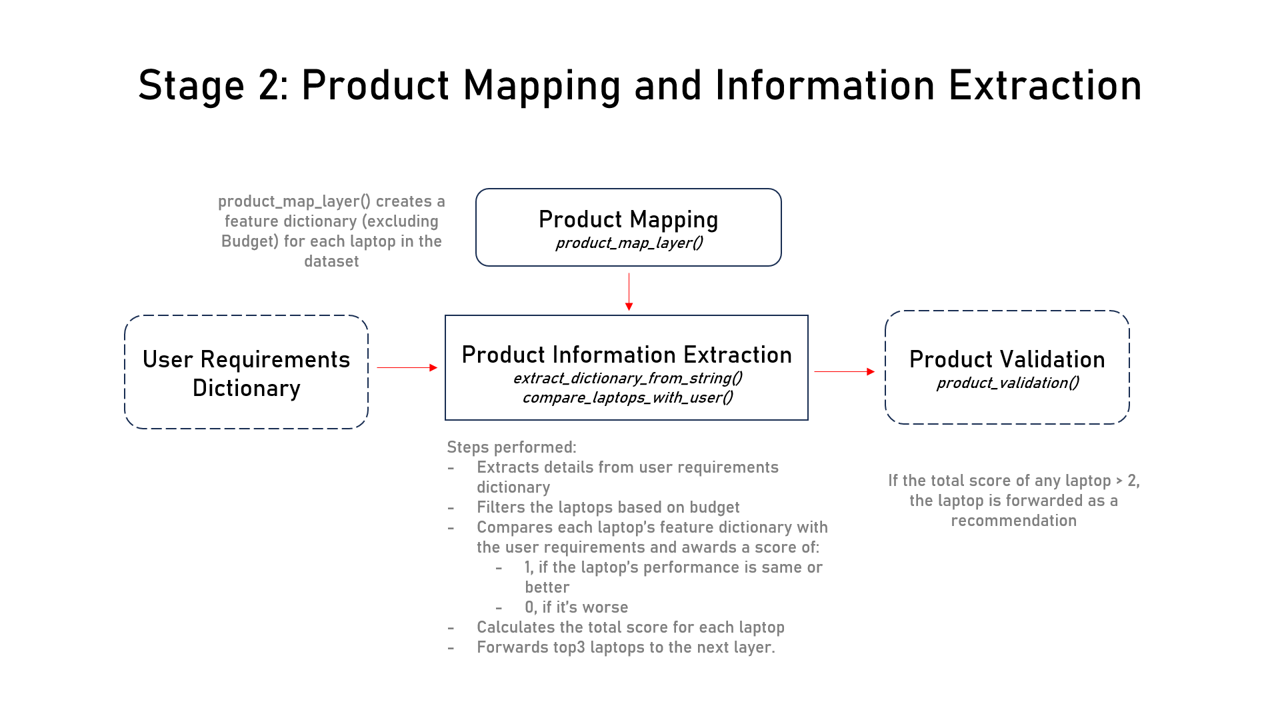

### B2.1 Extract product features from productDB

#### (a) [COMMON] extract_product_features()

In [40]:
def extract_product_features(laptop_description):
    delimiter = "#####"

    lap_spec = {
        "GPU intensity":"(Type of the Graphics Processor)",
        "Display quality":"(Display Type, Screen Resolution, Display Size)",
        "Portability":"(Laptop Weight)",
        "Multitasking":"(RAM Size)",
        "Processing speed":"(CPU Type, Core, Clock Speed)"
    }

    values = {"low", "medium", "high"}

    prompt=f'''
    You are a Laptop Specifications Classifier whose job is to extract the key features of laptops and classify them as per their requirements.
    To analyze each laptop, perform the following steps:
    Step 1: Extract the laptop's primary features from the description {laptop_description}
    Step 2: Store the extracted features in {lap_spec} \
    Step 3: Classify each of the items in {lap_spec} into {values} based on the following rules: \
    {delimiter}
    GPU Intensity:
    - low: <<< if GPU is entry-level such as an integrated graphics processor or entry-level dedicated graphics like Intel UHD >>> , \n
    - medium: <<< if mid-range dedicated graphics like M1, AMD Radeon, Intel Iris >>> , \n
    - high: <<< high-end dedicated graphics like Nvidia RTX >>> , \n

    Display Quality:
    - low: <<< if resolution is below Full HD (e.g., 1366x768). >>> , \n
    - medium: <<< if Full HD resolution (1920x1080) or higher. >>> , \n
    - high: <<< if High-resolution display (e.g., 4K, Retina) with excellent color accuracy and features like HDR support. >>> \n

    Portability:
    - high: <<< if laptop weight is less than 1.51 kg >>> , \n
    - medium: <<< if laptop weight is between 1.51 kg and 2.51 kg >>> , \n
    - low: <<< if laptop weight is greater than 2.51 kg >>> \n

    Multitasking:
    - low: <<< If RAM size is 8 GB, 12 GB >>> , \n
    - medium: <<< if RAM size is 16 GB >>> , \n
    - high: <<< if RAM size is 32 GB, 64 GB >>> \n

    Processing Speed:
    - low: <<< if entry-level processors like Intel Core i3, AMD Ryzen 3 >>> , \n
    - medium: <<< if Mid-range processors like Intel Core i5, AMD Ryzen 5 >>> , \n
    - high: <<< if High-performance processors like Intel Core i7, AMD Ryzen 7 or higher >>> \n
    {delimiter}

    {delimiter}
    Here is input output pair for few-shot learning:
    input 1: "The Dell Inspiron is a versatile laptop that combines powerful performance and affordability. It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing. With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity. The laptop sports a vibrant 15.6" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience. Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage. Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience. With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment. All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users."
    output 1: {{"GPU intensity": "medium","Display quality":"medium","Portability":"medium","Multitasking":"high","Processing speed":"medium"}}

    {delimiter}
    ### Strictly do not keep any other text in the values of the JSON dictionary other than low or medium or high. ###
    '''
    input = f"""
        Follow the above instructions step-by-step
        and output the dictionary in JSON format {lap_spec} for the following laptop {laptop_description}.
        Remember that, there is no wrapper field of the JSON. Otherwise you will be a big penalty
    """
    #see that we are using the Completion endpoint and not the Chatcompletion endpoint
    messages=[{"role": "system", "content":prompt },{"role": "user","content":input}]

    response = get_chat_completions(messages, json_format = True)

    return response

In [41]:
laptop_description_tc1 = f"""
The Dell Inspiron is a versatile laptop that combines powerful performance and affordability.
It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing.
With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity.
The laptop sports a vibrant 15.6" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience.
Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage.
Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience.
With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment.
All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users.
"""

extract_product_features(laptop_description=laptop_description_tc1)

{'GPU intensity': 'low',
 'Display quality': 'medium',
 'Portability': 'medium',
 'Multitasking': 'low',
 'Processing speed': 'medium'}

In [42]:
iterate_llm_response(
    funct = extract_product_features,
    funct_params = laptop_description_tc1,
    num = 3
)

Iteration: 0
{'GPU intensity': 'low', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'low', 'Processing speed': 'medium'}
--------------------------------------------------
Iteration: 1
{'GPU intensity': 'low', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'low', 'Processing speed': 'medium'}
--------------------------------------------------
Iteration: 2
{'GPU intensity': 'low', 'Display quality': 'medium', 'Portability': 'medium', 'Multitasking': 'low', 'Processing speed': 'medium'}
--------------------------------------------------


#### (b) Apply extraction func to product dataset

In [43]:
## Create a new column "laptop_feature" that contains the dictionary of the product features
df_product['Laptop Feature'] = df_product['Description'].apply(lambda x: extract_product_features(x))

df_product.head()

,Brand,Model Name,Core,CPU Manufacturer,Clock Speed,RAM Size,Storage Type,Display Type,Display Size,Graphics Processor,Screen Resolution,OS,Laptop Weight,Special Features,Warranty,Average Battery Life,Price,Description,Laptop Feature
0,Dell,Inspiron,i5,Intel,2.4 GHz,8GB,SSD,LCD,"15.6""",Intel UHD,1920x1080,Windows 10,2.5 kg,Backlit Keyboard,1 year,6 hours,"35,000",The Dell Inspiron is a versatile laptop that c...,"{'GPU intensity': 'low', 'Display quality': 'm..."
1,MSI,GL65,i7,Intel,2.6 GHz,16GB,HDD+SSD,IPS,"15.6""",NVIDIA GTX,1920x1080,Windows 10,2.3 kg,RGB Keyboard,2 years,4 hours,"55,000",The MSI GL65 is a high-performance laptop desi...,"{'GPU intensity': 'high', 'Display quality': '..."
2,HP,EliteBook,i7,Intel,2.8 GHz,16GB,SSD,LED,"14""",Intel UHD,1920x1080,Windows 11,1.5 kg,Fingerprint Sensor,3 years,8 hours,"90,000",The HP EliteBook is a premium laptop designed ...,"{'GPU intensity': 'low', 'Display quality': 'm..."
3,Lenovo,IdeaPad,i3,Intel,2.1 GHz,8GB,HDD,TN,"15.6""",Intel UHD,1366x768,Windows 10,2.2 kg,Dolby Audio,1 year,5 hours,"25,000",The Lenovo IdeaPad is a versatile laptop that ...,"{'GPU intensity': 'low', 'Display quality': 'l..."
4,ASUS,ZenBook Pro,i9,Intel,3.1 GHz,64GB,SSD,OLED,"15.6""",NVIDIA RTX,3840x2160,Windows 10,1.8 kg,NanoEdge Display,2 years,7 hours,"200,000",The ASUS ZenBook Pro is a high-end laptop that...,"{'GPU intensity': 'high', 'Display quality': '..."


In [44]:
df_product.to_csv("updated_laptop.csv",index=False,header = True)

### B2.2 Search products based on user intent

In [61]:
import pandas as pd  # Importing the pandas library for data manipulation
import json
import ast

def search_products(user_req_dict):
    if isinstance(user_req_dict, dict) == False:
        print("The variable is not a dictionary.")
        return json.dumps(None)

    # Extracting the budget value (numerical) from user_requirements
    budget = user_req_dict['Budget']

    # Mapping ranking for feature
    mapping = {'low': 0, 'medium': 1, 'high': 2}
    user_req_dict = {key: mapping[val] for key, val in user_req_dict.items() if key!='Budget'}

    # Read product DB
    laptop_df = pd.read_csv('updated_laptop.csv')

    # Filter laptops which price <= budget
    filtered_laptops = laptop_df.copy()
    filtered_laptops['Price'] = filtered_laptops['Price'].str.replace(',', '').astype(int)
    filtered_laptops = filtered_laptops[filtered_laptops['Price'] <= budget].copy()


    # Initialize Score column
    filtered_laptops['Score'] = 0

    # Calculate scores for every product based on user requirements
    for index, row in filtered_laptops.iterrows():
        # 1. convert feature string to dictionary
        laptop_features_dict = ast.literal_eval(row['Laptop Feature'])

        # 2. mapping the categorical to numerical
        laptop_features_dict = {key:mapping[val] for key, val in laptop_features_dict.items()}

        # 3. Compare 2 dictionary
        score = 0
        for key in user_req_dict:
            if laptop_features_dict[key] >= user_req_dict[key]:
                score += 1
        filtered_laptops.loc[index, 'Score'] = score

    # Select top 3 products which have score>=average
    filtered_laptops = filtered_laptops[filtered_laptops['Score'] >=3]
    top_laptops = filtered_laptops.sort_values('Score', ascending=False).head(3)


    # Convert top product to json and return to caller
    top_laptops_json = top_laptops.to_json(orient='records')  # Converting the top laptops DataFrame to JSON format

    return top_laptops_json

In [50]:
matched_products = search_products(request_dict)
matched_products

The variable is not a dictionary.


'null'

## B3. [Stage 3] Present recommendations

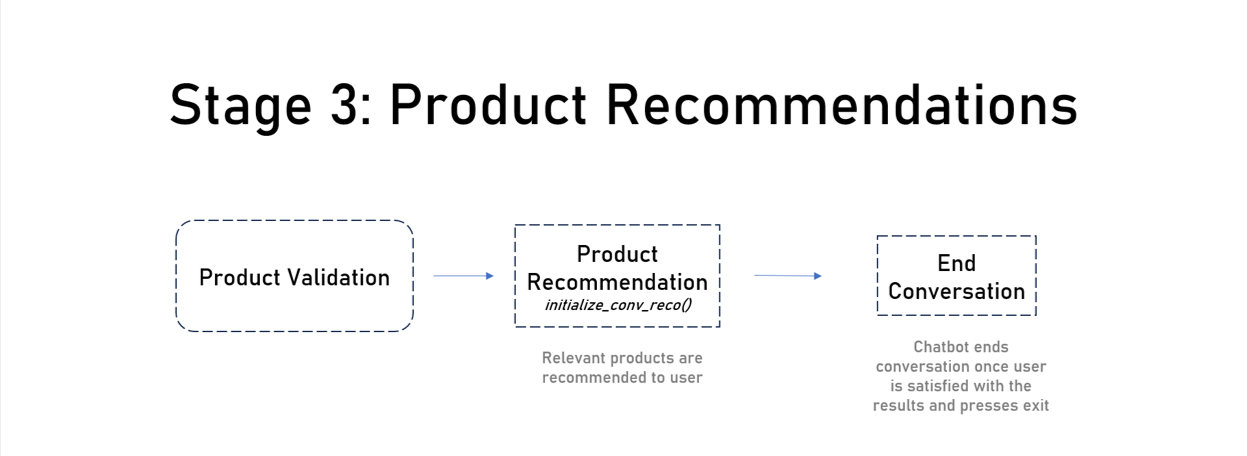

### B3.1 [COMMON] present_recommendation()

In [51]:
def present_recomendations(products):
    system_message = f"""
    You are an intelligent laptop gadget expert and you are tasked with the objective to \
    solve the user queries about any product from the catalogue in the user message \
    You should keep the user profile in mind while answering the questions.\

    Start with a brief summary of each laptop in the following format, in decreasing order of price of laptops:
    1. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>
    2. <Laptop Name> : <Major specifications of the laptop>, <Price in Rs>

    """
    user_message = f""" These are the user's products: {products}"""
    conversation = [{"role": "system", "content": system_message },
                    {"role":"user","content":user_message}]

    recommentation_message = get_chat_completions(conversation)
    return recommentation_message


In [52]:
print(present_recomendations(matched_products))

It seems that you don't have any specific products listed in your profile. However, I can provide a summary of some laptops from our catalog. Here are two laptops in decreasing order of price:

1. **Dell XPS 15**: Intel Core i7, 16GB RAM, 1TB SSD, NVIDIA GeForce GTX 1650 Ti, 15.6 inch 4K OLED display, Excellent build quality, Price: Rs 1,80,000
2. **HP Pavilion 14**: Intel Core i5, 8GB RAM, 512GB SSD, Intel UHD Graphics, 14 inch Full HD display, Affordable and lightweight, Price: Rs 55,000

If you have specific requirements or a budget in mind, please let me know, and I can provide more tailored suggestions!


# C. Dialog Management System

In [66]:
def dialog_mgmt():
    req_dict, chat_history = clarify_intent()

    products_json = search_products(req_dict)

    print(present_recomendations(products_json))

In [67]:
dialog_mgmt()

I am a Sales Assistant to help you to buy the best laptop. Please enter your questions:

YOU (your message or exit): I want to buy a laptop for accounting works

---------------

ASSISTANT:  Welcome! I'd be happy to help you find the right laptop for your accounting work. 

Could you please tell me if you require software that demands high multitasking, 
like handling spreadsheets, reports, or any specialized accounting tools? 
Additionally, will you be using it more at a desk or need to take it on-the-go?

YOU (your message or exit): yes, I handle a lot of spreadsheets, reporting, do with excel and power BI and other ERP web applications

---------------

ASSISTANT:  Thank you for sharing that information! It sounds like you need a laptop with high multitasking capability to handle spreadsheets 
and reports effectively. 

Could you also let me know about the importance of display quality for your work? 
Do you need a high-resolution display for clarity, or is standard quality sufficie